In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/home/joo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Step 1: Compute the Thruster’s Control Input
* Plot the PWM signal (µs) as a function of thrust (N) for a 12V
battery.

* Find a linear interpolation equation for negative and positive thrusts.

In [ ]:
# Load the Excel file
file_path = "/home/joo/Downloads/T200-Public-Performance-Data-10-20V-September-2019.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the file
xls.sheet_names

['READ ME FIRST', '10 V', '12 V', '14 V', '16 V', '18 V', '20 V']

In [ ]:
# Load the sheet corresponding to 12V battery data
df_12V = pd.read_excel(xls, sheet_name="16 V")

# Display the first few rows to understand the structure of the data
df_12V.head()

,PWM (µs),RPM,Current (A),Voltage (V),Power (W),Force (Kg f),Efficiency (g/W)
0,1100,3464.713333,24.298333,16,388.773333,-4.069476,10.467466
1,1104,3468.010000,24.300000,16,388.800000,-4.050577,10.418150
2,1108,3449.070000,23.780000,16,380.480000,-4.023361,10.574435
3,1112,3421.120000,23.250000,16,372.000000,-3.964394,10.656973
4,1116,3409.950000,22.640000,16,362.240000,-3.900891,10.768803


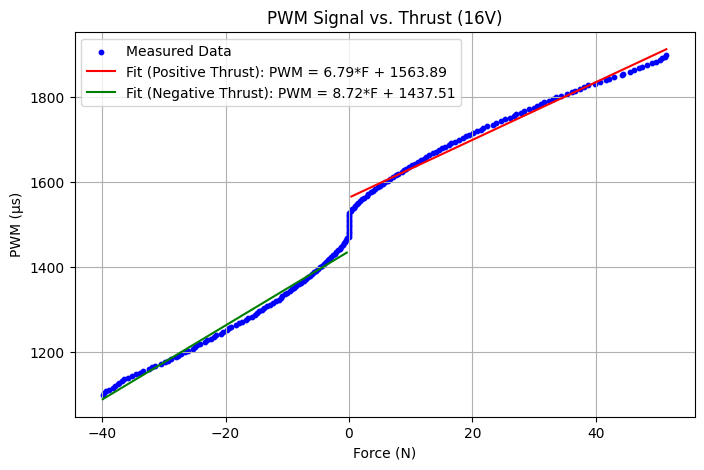

(array([   6.78996477, 1563.8915056 ]), array([   8.72219632, 1437.51054886]))

In [ ]:
# Trim whitespace from column names
df_12V.columns = df_12V.columns.str.strip()

# Extract relevant columns again
df_12V = df_12V[["PWM (µs)", "Force (Kg f)"]].dropna()

# Convert Force from Kg f to Newtons (1 Kg f ≈ 9.81 N)
df_12V["Force (N)"] = df_12V["Force (Kg f)"] * 9.81

# Separate positive and negative thrusts
df_pos = df_12V[df_12V["Force (N)"] > 0]
df_neg = df_12V[df_12V["Force (N)"] < 0]

# Fit linear approximations
coeff_pos = np.polyfit(df_pos["Force (N)"], df_pos["PWM (µs)"], 1)
coeff_neg = np.polyfit(df_neg["Force (N)"], df_neg["PWM (µs)"], 1)

# Generate fitted lines
force_range_pos = np.linspace(df_pos["Force (N)"].min(), df_pos["Force (N)"].max(), 100)
force_range_neg = np.linspace(df_neg["Force (N)"].min(), df_neg["Force (N)"].max(), 100)
pwm_fit_pos = np.polyval(coeff_pos, force_range_pos)
pwm_fit_neg = np.polyval(coeff_neg, force_range_neg)

# Plot the data and the fitted lines
plt.figure(figsize=(8, 5))
plt.scatter(df_12V["Force (N)"], df_12V["PWM (µs)"], label="Measured Data", color="blue", s=10)
plt.plot(force_range_pos, pwm_fit_pos, label=f"Fit (Positive Thrust): PWM = {coeff_pos[0]:.2f}*F + {coeff_pos[1]:.2f}", color="red")
plt.plot(force_range_neg, pwm_fit_neg, label=f"Fit (Negative Thrust): PWM = {coeff_neg[0]:.2f}*F + {coeff_neg[1]:.2f}", color="green")

plt.xlabel("Force (N)")
plt.ylabel("PWM (µs)")
plt.title("PWM Signal vs. Thrust (16V)")
plt.legend()
plt.grid()
plt.show()

# Display equations
coeff_pos, coeff_neg

## Step 2: Validate the Thruster’s Model
### Task:
* Measure floatability using a 1.5L bottle of water.
* Compute PWM values needed to compensate for floatability.
* Apply the computed PWM values to the ROV and check if the bottle almost submerges.

### Solution:
Floatability $F_{float}$ is the force required to keep the ROV neutrally buoyant. If the bottle is 1.5L of water, it provides 1.5 kg of buoyancy which is equal to 14.72 N. If you want to keep your ROV at neural buoyancy, the total force which comes from thrusters should be equal to $F_{float}$.

#### For neutral buoyancy:

PWM = 9.44 * 14.72 + 1568.18 = 1707.1368 -> FOR POSITIVE THRUST

In conclusion, we need to set PWM = 1707.1368 on the vertical thrusters.

## Step 3: Implement a Proportional Depth Controller
* $f_z = K_p \times (z_{des} - z)$


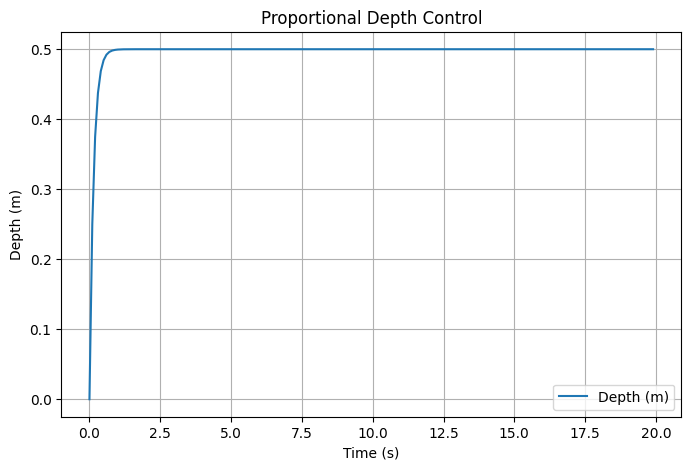

In [ ]:
# Define parameters
Kp = 5  # Initial guess for Kp (to be tuned)
z_des = 0.5  # Desired depth in meters
z = 0  # Initial depth

# Time simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 20, dt)  # 20 seconds simulation
depth = []
thrust_force = []

for t in time:
    error = z_des - z  # Compute depth error
    f_z = Kp * error  # Compute control force
    pwm = 9.44 * f_z + 1568.18  # Convert force to PWM

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt  # Simulate depth change

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, depth, label="Depth (m)")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.title("Proportional Depth Control")
plt.legend()
plt.grid()
plt.show()

## Step 4: Implement Floatability Compensation
Modifiying the P controller to:
$f_z = K_p (z_{des} - z) + F_{float}$



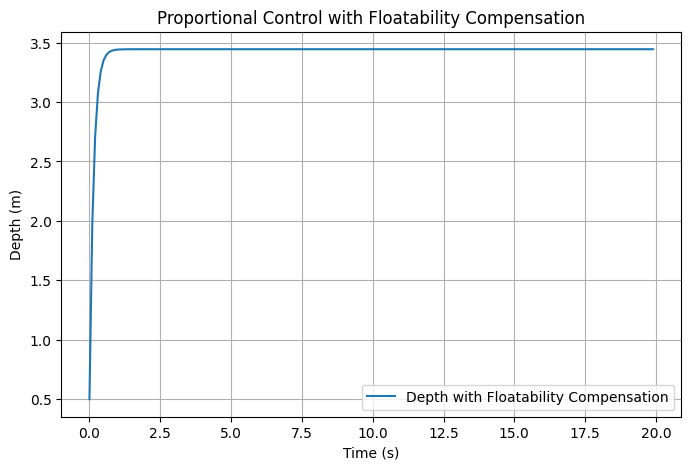

In [ ]:
F_float = 14.72  # Floatability force in N

depth = []
thrust_force = []

for t in time:
    error = z_des - z
    f_z = Kp * error + F_float  # Adding floatability compensation
    pwm = 9.44 * f_z + 1568.18

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, depth, label="Depth with Floatability Compensation")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.title("Proportional Control with Floatability Compensation")
plt.legend()
plt.grid()
plt.show()

## Step 5: Implement a Smooth Trajectory
Using a cubic polynomial:


$z_{desired} = z_{init} + a_2 t^2 + a_3 t^3$



$a_2 = \frac{3 (z_{final} - z_{init})}{t_{final}^2}, \quad
a_3 = \frac{-2 (z_{final} - z_{init})}{t_{final}^3}$

In [ ]:
class TrajPublisher(Node):

    def __init__(self):
        super().__init__('traj_publisher')
        self.publisher_ = self.create_publisher(float64, 'trajtory', 10)
        timer_period = 0.5  # seconds
        self.timer = self.create_timer(timer_period, self.timer_callback)
        self.i = 0

    def timer_callback(self):
        msg = String()
        msg.data = 'Hello World: %d' % self.i
        self.publisher_.publish(msg)
        self.get_logger().info('Publishing: "%s"' % msg.data)
        self.i += 1

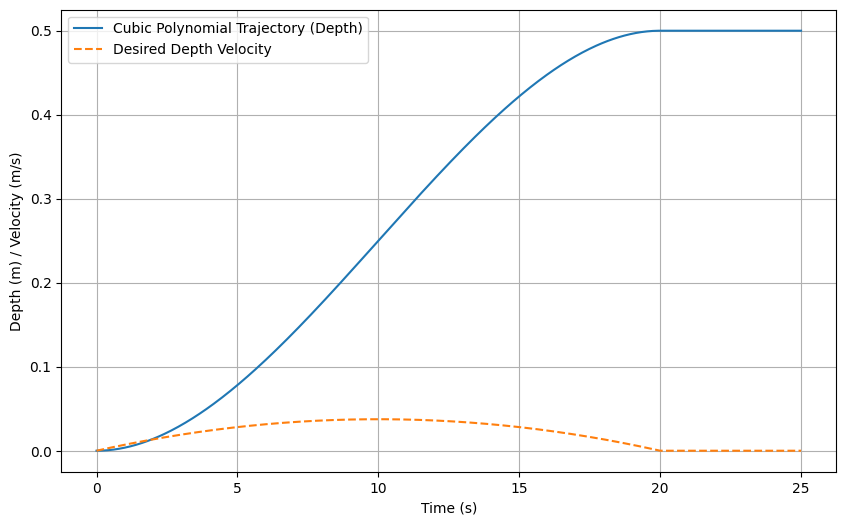

In [ ]:
# 초기 설정 값
z_init = 0
z_final = 0.5
t_final = 20

# 시간 배열 (예: t_final보다 조금 더 긴 시간까지 관찰)
time = np.linspace(0, t_final + 5, 500)

# 계수 계산 (Cubic polynomial)
a2 = (3 * (z_final - z_init)) / (t_final ** 2)
a3 = (-2 * (z_final - z_init)) / (t_final ** 3)

# 깊이 궤적 계산
z_trajectory = [
    z_init + a2 * t**2 + a3 * t**3 if t < t_final else z_final
    for t in time
]

# 깊이의 미분값 (속도) 계산:
# t < t_final 인 경우 : z_dot = 2*a2*t + 3*a3*t^2,
# t >= t_final 인 경우 : z_dot = 0
z_dot_trajectory = [
    2 * a2 * t + 3 * a3 * t**2 if t < t_final else 0
    for t in time
]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(time, z_trajectory, label="Cubic Polynomial Trajectory (Depth)")
plt.plot(time, z_dot_trajectory, label="Desired Depth Velocity", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m) / Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

## Step 6: Implement PID and External Disturbance Tests
Now, we will use a smooth cubic polynomial trajectory as the desired depth $(z_{desired})$ and implement a P controller with floatability compensation

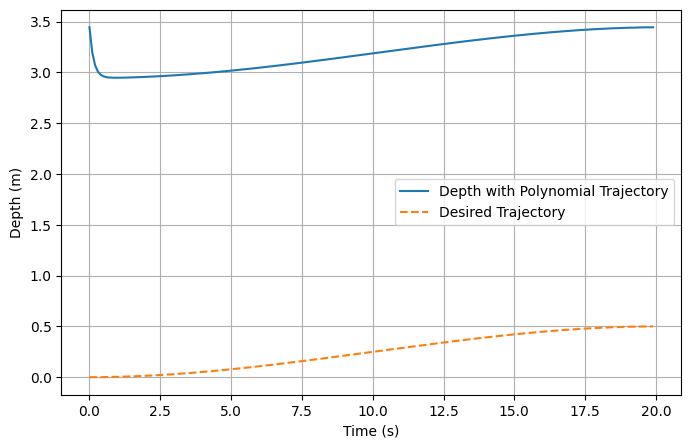

In [ ]:
depth = []
thrust_force = []

for i, t in enumerate(time):
    z_des = z_trajectory[i]  # Get the desired depth from trajectory
    error = z_des - z  # Compute depth error
    f_z = Kp * error + F_float  # Compute control force with floatability compensation
    pwm = 9.44 * f_z + 1568.18  # Convert force to PWM

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt  # Simulate depth change

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, depth, label="Depth with Polynomial Trajectory")
plt.plot(time, z_trajectory, '--', label="Desired Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid()
plt.show()

## Step 7: Implementing a PI Controller:
A Proportional Controller (P) results in a steady-state error due to unaccounted forces like buoyancy. To eliminate this error, we need to use an integral term:
* $\tau_z = K_p \tilde{z} + K_i \int \tilde{z}(t) dt + \text{floatability}$

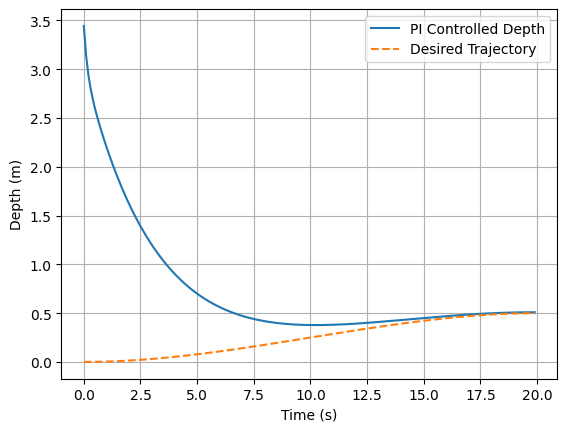

In [ ]:
Ki = 1.5  # Integral gain
integral = 0

depth = []
thrust_force = []

for i, t in enumerate(time):
    z_des = z_trajectory[i]
    error = z_des - z
    integral += error * dt  # Accumulate integral error
    f_z = Kp * error + Ki * integral + F_float  # PI Control
    pwm = 9.44 * f_z + 1568.18

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt

# Plot PI Response
plt.plot(time, depth, label="PI Controlled Depth")
plt.plot(time, z_trajectory, '--', label="Desired Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid()
plt.show()

## Step 8: Checking Robustness to External Disturbances

We need to check depth tracking before and after adding a 1.5L plastic bottle and compare the results


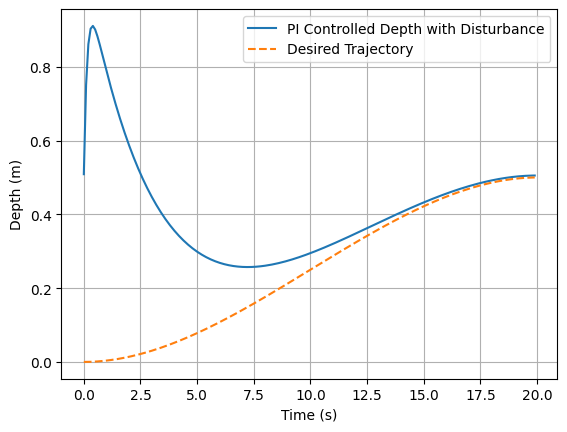

In [ ]:
# Disturbance: Adding buoyancy force
F_extra = 5  # Additional floatability force due to bottle

depth = []
thrust_force = []

for i, t in enumerate(time):
    z_des = z_trajectory[i]
    error = z_des - z
    integral += error * dt
    f_z = Kp * error + Ki * integral + F_float + F_extra  # PI with disturbance
    pwm = 9.44 * f_z + 1568.18

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt

# Plot Disturbance Response
plt.plot(time, depth, label="PI Controlled Depth with Disturbance")
plt.plot(time, z_trajectory, '--', label="Desired Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid()
plt.show()

## Step 9: Estimating Vertical Speed (Heave) with an Alpha-Beta Filter

The ROV has no direct sensor for vertical speed. Additionally, this filter is the best way to estimate from depth measurements.


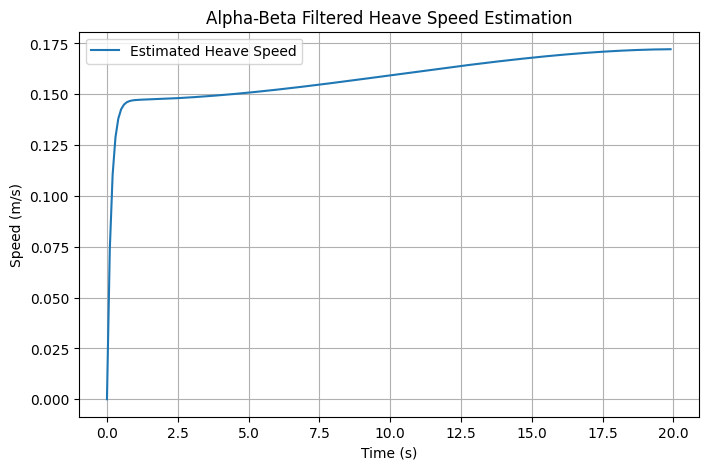

In [ ]:
# Define parameters
alpha = 0.1
beta = 0.005
heave_speed = 0
z = 0  # Initial depth
dt = 0.1  # Time step
time = np.arange(0, 20, dt)  # 20 seconds simulation

depth = [z]  # Initialize with the first depth value
estimated_speed = [0]  # Initialize speed estimate

for i, t in enumerate(time):
    z_des = z_trajectory[i]
    error = z_des - z

    # Proportional Control
    f_z = 5 * error + 14.72  # Kp = 5, floatability compensation
    pwm = 9.44 * f_z + 1568.18

    # Alpha-Beta filter for speed estimation
    if i == 0:
        heave_speed = 0  # No previous depth to compare in first iteration
    else:
        heave_speed = heave_speed + beta * (z - depth[-1]) / dt  # Correction step

    # Store depth and estimated speed
    depth.append(z)
    estimated_speed.append(heave_speed)

    # Simulate depth change
    z += f_z * dt

# Plot Heave Speed Estimation
plt.figure(figsize=(8, 5))
plt.plot(time, estimated_speed[1:], label="Estimated Heave Speed")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Alpha-Beta Filtered Heave Speed Estimation")
plt.legend()
plt.grid()
plt.show()

## Step 10: Implementing a Full PID Controller:
- PI control eliminates steady-state error but may cause oscillations.
- $Kd$ - derivative term which improves stability.
- Full PID Control: $\tau_{PID} = K_p \tilde{z} + K_i \int \tilde{z}(t) dt + K_d \dot{\tilde{z}} + \text{floatability}$

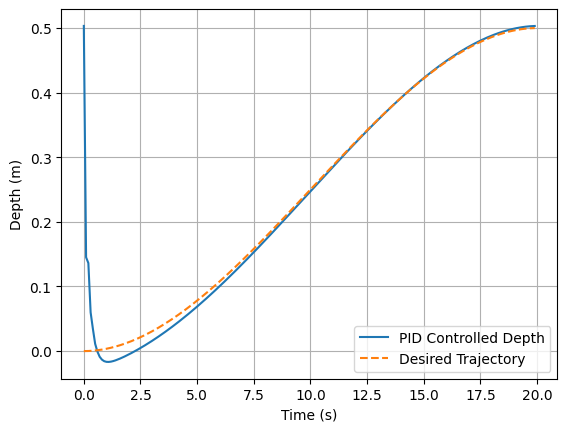

In [ ]:
Kd = 0.2  # Derivative gain
previous_error = 0

depth = []
thrust_force = []

for i, t in enumerate(time):
    z_des = z_trajectory[i]
    error = z_des - z
    integral += error * dt
    derivative = (error - previous_error) / dt  # Compute derivative term
    f_z = Kp * error + Ki * integral + Kd * derivative + F_float
    pwm = 9.44 * f_z + 1568.18

    depth.append(z)
    thrust_force.append(pwm)

    z += f_z * dt
    previous_error = error

# Plot PID Response
plt.plot(time, depth, label="PID Controlled Depth")
plt.plot(time, z_trajectory, '--', label="Desired Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid()
plt.show()

#From exercise 6

In [ ]:
#!/usr/bin/env python

import rclpy
import traceback
import numpy as np
import math
import csv
import os
from datetime import datetime
from rclpy.node import Node
from rclpy.qos import QoSProfile, QoSReliabilityPolicy, QoSHistoryPolicy
from struct import pack, unpack
from std_msgs.msg import Int16, Float64, Empty, Float64MultiArray, String
from sensor_msgs.msg import Joy, Imu, FluidPressure, LaserScan
from mavros_msgs.srv import CommandLong, SetMode, StreamRate
from mavros_msgs.msg import OverrideRCIn, Mavlink
from mavros_msgs.srv import EndpointAdd
from geometry_msgs.msg import Twist



# from waterlinked_a50_ros_driver.msg import DVL
# from waterlinked_a50_ros_driver.msg import DVLBeam

class MyPythonNode(Node):
    def __init__(self):
        super().__init__("listenerMIR")
        self.get_logger().info("This node is named listenerMIR")

         # ✅ 현재 시간을 기반으로 CSV 파일 이름 생성 (YYYYMMDD_HHMMSS)
        now = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.csv_filename = f"depth_data_{now}.csv"

        # ✅ 새 CSV 파일을 생성하고 헤더를 추가
        with open(self.csv_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Time", "Depth", "Correction_depth", "Heave"])

        self.ns = self.get_namespace()
        self.get_logger().info("namespace =" + self.ns)
        self.pub_msg_override = self.create_publisher(OverrideRCIn, "rc/override", 10)
        self.pub_angle_degre = self.create_publisher(Twist, 'angle_degree', 10)
        self.pub_depth = self.create_publisher(Float64, 'depth', 10)
        self.pub_angular_velocity = self.create_publisher(Twist, 'angular_velocity', 10)
        self.pub_linear_velocity = self.create_publisher(Twist, 'linear_velocity', 10)
        self.pub_heave = self.create_publisher(Float64, "heave", 10)
        self.get_logger().info("Publishers created.")

        self.get_logger().info("ask router to create endpoint to enable mavlink/from publication.")
        # self.addEndPoint()

        self.armDisarm(False)  # Not automatically disarmed at startup
        rate = 25  # 25 Hz
        self.setStreamRate(rate)
        # self.manageStabilize(False)

        #----------for step 7 ----------------
        self.prev_error = 0.0  # 이전 오차 (D 제어를 위해 필요)
        self.integral_error = 0.0  # initialize error
        self.sampling_period = 0.05  # 20Hz sampling frequency
        self.Kp = 6.0  # KP
        self.Ki = 0.0  # KI (we need to tune it )
        self.Kd = 0.1  # D 게인 (기본값: 0, 필요시 조정)
        self.flotability = self.NewToPWM(3)  # floatability
        #-----------for step 9 ---------#
        self.alpha = 0.1  # Alpha-Beta  α
        self.beta = 0.005  # Alpha-Beta β
        self.dt = 1.0 / 58.0
        self.z_hat = None  # estimated z with filtering(초기화 필요)
        self.w_hat = 0.0  # initilaze(Heave) velocity

        # initilaze and call trajectory
        self.received_trajectory = None


        self.subscriber()



        # set timer if needed
        timer_period = 0.05  # 50 msec - 20 Hz
        self.timer = self.create_timer(timer_period, self.timer_callback)
        self.i = 0

        # variables
        self.set_mode = [0] * 3
        self.set_mode[0] = True  # Mode manual
        self.set_mode[1] = False  # Mode automatic without correction
        self.set_mode[2] = False  # Mode with correction

        # Conditions
        self.init_a0 = True
        self.init_p0 = True
        self.arming = False

        self.angle_roll_ajoyCallback0 = 0.0
        self.angle_pitch_a0 = 0.0
        self.angle_yaw_a0 = 0.0
        self.depth_wrt_startup = 0
        self.depth_p0 = 0

        self.pinger_confidence = 0
        self.pinger_distance = 0

        self.Vmax_mot = 1900
        self.Vmin_mot = 1100

        # corrections for control
        self.Correction_yaw = 1500
        self.Correction_depth = 1500

    def timer_callback(self):
        # msg = String()
        # msg.data = 'Hello World: %d' % self.i
        # self.publisher_.publish(msg)
        # self.get_logger().info('Publishing: "%s"' % msg.data)
        # self.i += 1
        if self.received_trajectory is not None:
            msg = Float64()
            msg.data = self.received_trajectory  # 구독한 값 사용
            self.pub_depth.publish(msg)
            self.get_logger().info(f"Publishing depth: {msg.data:.4f}")
        else:
            self.get_logger().warn("No trajectory data received yet, skipping depth publishing.")

        if self.set_mode[0]:  # commands sent inside joyCallback()
            return
        elif self.set_mode[1]:  # Arbitrary velocity command can be defined here to observe robot's velocity, zero by default
            self.setOverrideRCIN(1500, 1500, 1500, 1500, 1500, 1500)
            return
        elif self.set_mode[2]:
            # send commands in correction mode
            self.setOverrideRCIN(1500, 1500, self.Correction_depth, self.Correction_yaw, 1500, 1500)
        else:  # normally, never reached
            pass

    def armDisarm(self, armed):
        # This functions sends a long command service with 400 code to arm or disarm motors
        if (armed):
            traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
            cli = self.create_client(CommandLong, 'cmd/command')
            result = False
            while not result:
                result = cli.wait_for_service(timeout_sec=4.0)
                self.get_logger().info("arming requested, wait_for_service, timeout, result :" + str(result))
            req = CommandLong.Request()
            req.broadcast = False
            req.command = 400
            req.confirmation = 0
            req.param1 = 1.0
            req.param2 = 0.0
            req.param3 = 0.0
            req.param4 = 0.0
            req.param5 = 0.0
            req.param6 = 0.0
            req.param7 = 0.0
            self.get_logger().info("just before call_async")
            resp = cli.call_async(req)
            self.get_logger().info("just after call_async")
            # rclpy.spin_until_future_complete(self, resp)
            self.get_logger().info("Arming Succeeded")
        else:
            traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
            cli = self.create_client(CommandLong, 'cmd/command')
            result = False
            while not result:
                result = cli.wait_for_service(timeout_sec=4.0)
                self.get_logger().info(
                    "disarming requested, wait_for_service, (False if timeout) result :" + str(result))
            req = CommandLong.Request()
            req.broadcast = False
            req.command = 400
            req.confirmation = 0
            req.param1 = 0.0
            req.param2 = 0.0
            req.param3 = 0.0
            req.param4 = 0.0
            req.param5 = 0.0
            req.param6 = 0.0
            req.param7 = 0.0
            resp = cli.call_async(req)
            # rclpy.spin_until_future_complete(self, resp)
            self.get_logger().info("Disarming Succeeded")

    def manageStabilize(self, stabilized):
        # This functions sends a SetMode command service to stabilize or reset
        if (stabilized):
            traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
            cli = self.create_client(SetMode, 'set_mode')
            result = False
            while not result:
                result = cli.wait_for_service(timeout_sec=4.0)
                self.get_logger().info(
                    "stabilized mode requested, wait_for_service, (False if timeout) result :" + str(result))
            req = SetMode.Request()
            req.base_mode = 0
            req.custom_mode = "0"
            resp = cli.call_async(req)
            # rclpy.spin_until_future_complete(self, resp)
            self.get_logger().info("set mode to STABILIZE Succeeded")

        else:
            traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
            result = False
            cli = self.create_client(SetMode, 'set_mode')
            while not result:
                result = cli.wait_for_service(timeout_sec=4.0)
                self.get_logger().info(
                    "manual mode requested, wait_for_service, (False if timeout) result :" + str(result))
            req = SetMode.Request()
            req.base_mode = 0
            req.custom_mode = "19"
            resp = cli.call_async(req)
            # rclpy.spin_until_future_complete(self, resp)
            self.get_logger().info("set mode to MANUAL Succeeded")

    def setStreamRate(self, rate):
        traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
        cli = self.create_client(StreamRate, 'set_stream_rate')
        result = False
        while not result:
            result = cli.wait_for_service(timeout_sec=4.0)
            self.get_logger().info("stream rate requested, wait_for_service, (False if timeout) result :" + str(result))

        req = StreamRate.Request()
        req.stream_id = 0
        req.message_rate = rate
        req.on_off = True
        resp = cli.call_async(req)
        rclpy.spin_until_future_complete(self, resp)
        self.get_logger().info("set stream rate Succeeded")

    def addEndPoint(self):
        traceback_logger = rclpy.logging.get_logger('node_class_traceback_logger')
        cli = self.create_client(EndpointAdd, 'mavros_router/add_endpoint')
        result = False
        while not result:
            result = cli.wait_for_service(timeout_sec=4.0)
            self.get_logger().info(
                "add endpoint requesRelAltCallbackted, wait_for_service, (False if timeout) result :" + str(result))

        req = EndpointAdd.Request()
        req.url = "udp://@localhost"
        req.type = 1  # TYPE_GCS
        resp = cli.call_async(req)
        rclpy.spin_until_future_complete(self, resp)
        self.get_logger().info("add endpoint rate Succeeded")

    def joyCallback(self, data):
        # Joystick buttons
        btn_arm = data.buttons[7]  # Start button
        btn_disarm = data.buttons[6]  # Back button
        btn_manual_mode = data.buttons[3]  # Y button
        btn_automatic_mode = data.buttons[2]  # X button
        btn_corrected_mode = data.buttons[0]  # A button

        # Disarming when Back button is pressed
        if (btn_disarm == 1 and self.arming == True):
            self.arming = False
            self.armDisarm(self.arming)

        # Arming when Start button is pressed
        if (btn_arm == 1 and self.arming == False):
            self.arming = True
            self.armDisarm(self.arming)

        # Switch manual, auto anset_moded correction mode
        if (btn_manual_mode and not self.set_mode[0]):
            self.set_mode[0] = True
            self.set_mode[1] = False
            self.set_mode[2] = False
            self.get_logger().info("Mode manual")
        if (btn_automatic_mode and not self.set_mode[1]):
            self.set_mode[0] = False
            self.set_mode[1] = True
            self.set_mode[2] = False
            self.get_logger().info("Mode automatic")
        if (btn_corrected_mode and not self.set_mode[2]):
            self.init_a0 = True
            self.init_p0 = True
            # set sum errors to 0 here, ex: Sum_Errors_Vel = [0]*3
            self.set_mode[0] = False
            self.set_mode[1] = False
            self.set_mode[2] = True
            self.get_logger().info("Mode correction")

    def velCallback(self, cmd_vel):
        # Only continue if manual_mode is enabled
        if (self.set_mode[1] or self.set_mode[2]):
            return
        else:
            self.get_logger().info("Sending...")

        # Extract cmd_vel message
        roll_left_right = self.mapValueScalSat(cmd_vel.angular.x)
        yaw_left_right = self.mapValueScalSat(-cmd_vel.angular.z)
        ascend_descend = self.mapValueScalSat(cmd_vel.linear.z)
        forward_reverse = self.mapValueScalSat(cmd_vel.linear.x)
        lateral_left_right = self.mapValueScalSat(-cmd_vel.linear.y)
        pitch_left_right = self.mapValueScalSat(cmd_vel.angular.y)

        self.setOverrideRCIN(pitch_left_right, roll_left_right, ascend_descend, yaw_left_right, forward_reverse,
                             lateral_left_right)

    def setOverrideRCIN(self, channel_pitch, channel_roll, channel_throttle, channel_yaw, channel_forward,
                        channel_lateral):
        # This function replaces setservo for motor commands.
        # It overrides Rc channels inputs and simulates motor controls.
        # In this case, each channel manages a group of motors not individually as servo set

        msg_override = OverrideRCIn()
        msg_override.channels[0] = np.uint(channel_pitch)  # pulseCmd[4]--> pitch
        msg_override.channels[1] = np.uint(channel_roll)  # pulseCmd[3]--> roll
        msg_override.channels[2] = np.uint(channel_throttle)  # pulseCmd[2]--> heave
        msg_override.channels[3] = np.uint(channel_yaw)  # pulseCmd[5]--> yaw
        msg_override.channels[4] = np.uint(channel_forward)  # pulseCmd[0]--> surge
        msg_override.channels[5] = np.uint(channel_lateral)  # pulseCmd[1]--> sway
        msg_override.channels[6] = 1500
        msg_override.channels[7] = 1500

        self.pub_msg_override.publish(msg_override)

    def mapValueScalSat(self, value):
        # Correction_Vel and joy between -1 et 1
        # scaling for publishing with setOverrideRCIN values between 1100 and 1900
        # neutral point is 1500
        pulse_width = value * 400 + 1500

        # Saturation
        if pulse_width > 1900:
            pulse_width = 1900
        if pulse_width < 1100:
            pulse_width = 1100

        return int(pulse_width)

    def OdoCallback(self, data):
        orientation = data.orientation
        angular_velocity = data.angular_velocity

        # extraction of roll, pitch, yaw angles
        x = orientation.x
        y = orientation.y
        z = orientation.z
        w = orientation.w

        sinr_cosp = 2.0 * (w * x + y * z)
        cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
        sinp = 2.0 * (w * y - z * x)
        siny_cosp = 2.0 * (w * z + x * y)
        cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
        angle_roll = np.arctan2(sinr_cosp, cosr_cosp)
        angle_pitch = np.arcsin(sinp)
        angle_yaw = np.arctan2(siny_cosp, cosy_cosp)

        if (self.init_a0):
            # at 1st execution, init
            self.angle_roll_a0 = angle_roll
            self.angle_pitch_a0 = angle_pitch
            self.angle_yaw_a0 = angle_yaw
            self.init_a0 = False

        angle_wrt_startup = [0] * 3
        angle_wrt_startup[0] = ((angle_roll - self.angle_roll_a0 + 3.0 * math.pi) % (
                    2.0 * math.pi) - math.pi) * 180 / math.pi
        angle_wrt_startup[1] = ((angle_pitch - self.angle_pitch_a0 + 3.0 * math.pi) % (
                    2.0 * math.pi) - math.pi) * 180 / math.pi
        angle_wrt_startup[2] = ((angle_yaw - self.angle_yaw_a0 + 3.0 * math.pi) % (
                    2.0 * math.pi) - math.pi) * 180 / math.pi

        angle = Twist()
        angle.angular.x = angle_wrt_startup[0]
        angle.angular.y = angle_wrt_startup[1]
        angle.angular.z = angle_wrt_startup[2]

        self.pub_angle_degre.publish(angle)

        # Extraction of angular velocity
        p = angular_velocity.x
        q = angular_velocity.y
        r = angular_velocity.z

        vel = Twist()
        vel.angular.x = p
        vel.angular.y = q
        vel.angular.z = r
        self.pub_angular_velocity.publish(vel)

        # Only continue if manual_mode is disabled
        if (self.set_mode[0]):
            return

        # Send PWM commands to motors
        # yaw command to be adapted using sensor feedback
        self.Correction_yaw = 1500


    def NewToPWM(self, newton):   # added 10.3
    	if newton < 0:
    		PWM = 8.72 * newton + 1468
    	elif newton > 0:
    		PWM = 6.79 * newton + 1532
    	else:
    		PWM = 1500

    	if PWM > 1900:
    		PWM = 1900
    	if PWM < 1100:
    		PWM = 1100

    	return PWM

    def RelAltCallback(self, data):
        if self.init_p0:
            # 1st execution:
            self.depth_p0 = data.data  # ✅ data.data 사용
            self.init_p0 = False

        # ✅ use Trajectory
        if self.received_trajectory is not None:
            z_desired = self.received_trajectory  # 목표 깊이
        else:
            self.get_logger().warn("No trajectory data received yet, using default depth.")
            z_desired = -0.5  # default

        # current depth
        z = data.data
#---------------------step 6 -----------------------
        # ✅ P controller
        Kp = self.Kp  # self.Kp 값을 사용하여 조정 가능
        error = z_desired - z  # 목표 깊이 - 현재 깊이
        Correction_depth = self.NewToPWM(Kp * error) - self.flotability  # ✅ 부력 보상 적용


        # ✅ save Correction_depth
        self.Correction_depth = max(1100, min(1900, int(Correction_depth)))


        # ✅ Log print
        self.get_logger().info(f"P Controller - z={z:.4f}, z_desired={z_desired:.4f}, Correction_depth={self.Correction_depth}")
    # Send PWM commands to motors in timer (self.timer_callback에서 처리)
    #-------------step 7 -------------------------------#
        '''

        # ✅ PI controller
        error = z_desired - z  # desired depth - current depth
        # **update the error term** (Anti-Windup 적용)
        self.integral_error += error * self.sampling_period
        self.integral_error = max(-10, min(10, self.integral_error))  # 적분 오차 제한

        # **P + I control equation **
        control_signal = (self.Kp * error) + (self.Ki * self.integral_error) - self.flotability

        pwm_signal = self.NewToPWM(control_signal)
        self.Correction_depth = max(1100, min(1900, int(pwm_signal)))

        # ✅ Log 출력 (디버깅용)
        self.get_logger().info(
            f"RelAltCallback: z={z:.4f}, z_desired={z_desired:.4f}, error={error:.4f}, "
            f"integral_error={self.integral_error:.4f}, Correction_depth={self.Correction_depth}"
        )


        '''
#------------------PID step 10 ------------------------------------------------
        """

        error = z_desired - z  # 목표 깊이 - 현재 깊이

    # *
        self.integral_error += error * self.sampling_period
        self.integral_error = max(-10, min(10, self.integral_error))  # 적분 오차 제한


        error_derivative = (error - self.prev_error) / self.sampling_period  # 오차 변화율


        control_signal = (self.Kp * error) + (self.Ki * self.integral_error) + (self.Kd * error_derivative) - self.flotability

        # **PWM 변환 및 안전한 범위 내로 제한**
        pwm_signal = self.NewToPWM(control_signal)
        self.Correction_depth = max(1100, min(1900, int(pwm_signal)))

        # **이전 오차 업데이트 (다음 루프에서 D 항 계산을 위해)**
        self.prev_error = error

        # ✅ 로그 출력 (디버깅용)
        self.get_logger().info(
            f"PID Controller - z={z:.4f}, z_desired={z_desired:.4f}, error={error:.4f}, "
            f"integral_error={self.integral_error:.4f}, error_derivative={error_derivative:.4f}, "
            f"Correction_depth={self.Correction_depth}"
        )










        """
    #-----------------step 9 --------------------------#

        if self.z_hat is None:
            self.z_hat = z
            self.w_hat = 0.0

        # Alpha-Beta filterapply
        z_pred = self.z_hat + self.w_hat * self.dt  # estimated depth
        z_residual = z - z_pred  # estimated error

        # update filter
        self.z_hat = z_pred + self.alpha * z_residual  # update depth
        self.w_hat = self.w_hat + self.beta * (z_residual / self.dt)  # hudate heave vel

        current_time = self.get_clock().now().to_msg().sec

        # ✅ save data in csv file
        with open(self.csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([current_time, z, self.Correction_depth, self.w_hat])

        # print log
        self.get_logger().info(f"Heave Estimation - Depth: {z:.4f}, Estimated Depth: {self.z_hat:.4f}, Heave: {self.w_hat:.4f}")

        heave_msg = Float64()
        heave_msg.data = self.w_hat
        self.pub_heave.publish(heave_msg)

        #-----------------step 9----------------





    def DvlCallback(self, data):
        u = data.velocity.x  # Linear surge velocity
        v = data.velocity.y  # Linear sway velocity
        w = data.velocity.z  # Linear heave velocity
        Vel = Twist()
        Vel.linear.x = u
        Vel.linear.y = v
        Vel.linear.z = w
        self.pub_linear_velocity.publish(Vel)

    # works but at 4hz compared with 25 Hz for global_position/rel_alt !
    # /uas1/mavlink_source runs at more than 500 Hz !
    # try with pyvmavlink using an udp connection, to see if gain in hz
    def mavlink_callback(self, data):
        # Check if message id is valid (I'm using SCALED_PRESSURE2)
        if data.msgid == 137:
            # self.get_logger().info("=> In mavlink_callback, msgid 137 SCALED_PRESSURE2, Package: " + str(data))
            # Transform the payload in a python string
            p = pack("QQ", *data.payload64)
            # Transform the string in valid values
            # https://docs.python.org/2/library/struct.html
            time_boot_ms, water_press_abs, press_diff, temperature = unpack("Iffhxx", p)

            # a priori, in hPa (hectoPascal)
            # self.get_logger().info("water_press_abs=" + str(water_press_abs))

            rho = 1000.0  # 1025.0 for sea water
            g = 9.80665

            # Only continue if correction mode is activated
            # if (self.set_mode[0] or self.set_mode[1]):
            #	return

            pressure = water_press_abs * 100.0

            if (self.init_p0):
                # 1st execution, init
                self.depth_p0 = (pressure - 101100) / (rho * g)
                self.init_p0 = False

            self.depth_wrt_startup = (pressure - 101100) / (rho * g) - self.depth_p0
            msg = Float64()
            msg.data = self.depth_wrt_startup
            self.pub_depth.publish(msg)

            # setup depth servo control here
            # ...

            # update Correction_depth

            Correction_depth = 1500
            self.Correction_depth = int(Correction_depth)
        # Send PWM commands to motors in timer

    def pingerCallback(self, data):
        self.pinger_distance = data.data[0]
        self.pinger_confidence = data.data[1]

    # self.get_logger().info("pinger_distance =" + str(self.pinger_distance))

    def subscriber(self):
        qos_profile = QoSProfile(
            reliability=QoSReliabilityPolicy.BEST_EFFORT,
            history=QoSHistoryPolicy.KEEP_LAST,
            depth=1
        )

        self.subjoy = self.create_subscription(Joy, "joy", self.joyCallback, qos_profile=qos_profile)
        self.subjoy  # prevent unused variable warning
        self.subcmdvel = self.create_subscription(Twist, "cmd_vel", self.velCallback, qos_profile=qos_profile)
        self.subcmdvel  # prevent unused variable warning
        self.subimu = self.create_subscription(Imu, "imu/data", self.OdoCallback, qos_profile=qos_profile)
        self.subimu  # prevent unused variable warning

        self.subrel_alt = self.create_subscription(Float64, "global_position/rel_alt", self.RelAltCallback,
                                                   qos_profile=qos_profile)
        self.subrel_alt  # prevent unused variable warning
        # self.subwater_pressure = self.create_subscription(Mavlink,"mavlink/from", self.mavlink_callback, qos_profile = qos_profile)
        # self.subwater_pressure = self.create_subscription(Mavlink,"/uas1/mavlink_source", self.mavlink_callback, qos_profile = qos_profile)
        # self.subwater_pressure # prevent unused variable warning

        # self.sub = self.create_subscription(DVL, "/dvl/data", DvlCallback)
        self.subping = self.create_subscription(Float64MultiArray, "ping1d/data", self.pingerCallback,
                                                qos_profile=qos_profile)
        self.subping  # prevent unused variable warning

        self.sub_trajectory = self.create_subscription(Float64, "trajectory", self.trajectory_callback, qos_profile=qos_profile)

        self.get_logger().info("Subscriptions done.")


    def trajectory_callback(self, msg):
        # 구독한 trajectory 값을 저장하는 콜백 함수 """
        if msg.data is not None:
            self.received_trajectory = msg.data
            self.get_logger().info(f"Received trajectory value: {msg.data:.4f}")


def main(args=None):
    rclpy.init(args=args)
    node = MyPythonNode()
    rclpy.spin(node)
    node.destroy_node()
    rclpy.shutdown()


if __name__ == "__main__":
    main()


# The file name is :
traj_publisher.py

In [ ]:
import rclpy
from rclpy.node import Node
from std_msgs.msg import Float64

class TrajPublisher(Node):
    def __init__(self):
        super().__init__('traj_publisher')
        self.publisher_ = self.create_publisher(Float64, 'trajectory', 10)

        self.z_init = 0.0
        self.z_final = 0.5
        self.t_final = 20.0
        self.a2 = (3 * (self.z_final - self.z_init)) / (self.t_final ** 2)
        self.a3 = (-2 * (self.z_final - self.z_init)) / (self.t_final ** 3)

        self.i = 0
        self.timer_period = 0.5  # 2Hz
        self.timer = self.create_timer(self.timer_period, self.timer_callback)

    def timer_callback(self):
        t = self.i * self.timer_period  # 현재 시간
        z = self.z_final if t >= self.t_final else self.z_init + self.a2 * t**2 + self.a3 * t**3

        msg = Float64()
        msg.data = z
        self.publisher_.publish(msg)
        self.get_logger().info(f'Publishing trajectory: {msg.data:.4f}')
        self.i += 1

def main(args=None):
    rclpy.init(args=args)
    node = TrajPublisher()
    rclpy.spin(node)
    node.destroy_node()
    rclpy.shutdown()

if __name__ == '__main__':
    main()


#In setup.py, add this code

In [ ]:
'traj_publisher = autonomous_rov.traj_publisher:main',

('traj_publisher = autonomous_rov.traj_publisher:main',)